## 必要工作

In [4]:
import tensorflow as tf
from keras.metrics import AUC
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.metrics import Precision, Recall
from keras.losses import BinaryCrossentropy
import datetime
from model.nn import multichannel_network
from model.data import Dataset, DataGenerator
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
import seaborn as sns
from config_path import *

import matplotlib.pyplot as plt

def plot_picture(history):
    '''
    画出训练集和验证集的损失和精度变化，分析模型状态
    :return:
    '''

    # 画出训练集和验证集的损失和精度变化，分析模型状态

    acc = history.history['auc_2']  # 训练集acc
    val_acc = history.history['val_auc_2']  # 验证集 acc
    loss = history.history['loss']  # 训练损失
    val_loss = history.history['val_loss']  # 验证损失
    epochs = range(1, len(acc) + 1)  # 迭代次数
    plt.plot(epochs, loss, 'bo', label='Training loss')  # bo for blue dot 蓝色点
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
 
    plt.clf()  # clar figure

    plt.plot(epochs, acc, 'bo', label='Training AUPRC')  # bo for blue dot 蓝色点
    plt.plot(epochs, val_acc, 'b', label='Validation AUPRC')
    plt.title('Training and validation AUPRC')
    plt.xlabel('Epochs')
    plt.ylabel('AUPRC')
    plt.legend()
    plt.show()
 
    plt.clf()

In [5]:
tf.random.set_seed(40)
# Dataset Setting: 
## choose from ['methylation', 'gene_expression', 'cnv', 'mutation']
FEATURE = ['gene_expression', 'methylation', 'mutation', 'cnv'] 
ds = Dataset(
    feature_contained=FEATURE, 
    dataset='CTRP', 
    set_label=True, 
    response='AUC', 
    threshold=.45)
# CTRP, "AUC", 0.58, 0.001, 0.45
# GDSC, "AUC", .88, 0.001. 0.87
# model parameters settings
ds.save()


Loading Copy Number Abberation Data...
Loading Copy Number Abberation Data Done
Loading Gene Expression Data...
Loading Gene Expression Data Done
Loading Methylation Data...


/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Loading Methylation Data Done
Loading Mutations Data...
Loading Mutations Data Done
Begin loading drug data...
After combining and alignment, unique cid number is 459


  0%|          | 0/459 [00:00<?, ?it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/_lib/_util.py:69: RuntimeWarning: overflow encountered in _ncx2_cdf
  np.place(out, cond, f(*temp))
/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6630: RuntimeWarning: overflow encountered in _ncf_cdf
  return _boost._ncf_cdf(x, dfn, dfd, nc)
  1%|          | 3/459 [00:00<00:41, 11.06it/s]/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
100%|██████████| 459/459 [00:37<00:00, 12.10it/s]


Drug data loaded
Loading CTRP Experiment Data...
Loading Experiment Data Done
Begin Preprocessing Experiment!
Select Overlapping Cellines...
Index(['CELLINE_BARCODE', 'DRUG_NAME', 'DATASET', 'AUC'], dtype='object')
Select Overlapping Cellines with available PubChem CIDs...
Create Unique Sample Barcode...
Exclude response value...
Experiment Done!
Preparing Omics data...
Omics data Done!
We have 156943 samples in dataset...
Save the dataset into hdf5 data format...
Done!


Distribution over test set

In [314]:
train_sample_barcode = pd.read_csv('result/train_sample_barcode.csv')['0']

<AxesSubplot:xlabel='AUC', ylabel='Count'>

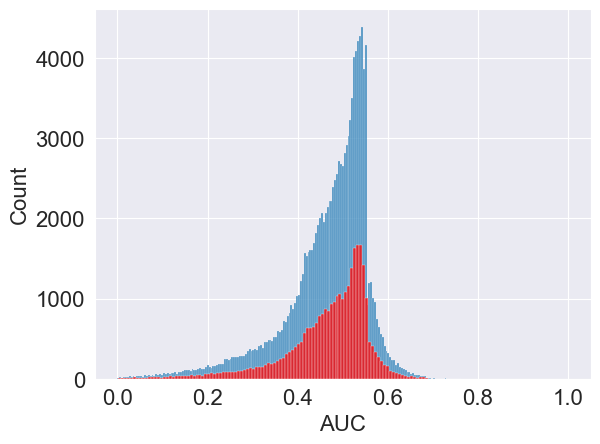

In [336]:
fig, ax = plt.subplots()
partition = ds.split(ds.sample_barcode)
train = partition['train']
test = partition['test']
validation = partition['validation']
sns.histplot(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(train_sample_barcode)]['AUC'])
sns.histplot(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(test+validation)]['AUC'], color='red')

In [378]:
from collections import Counter
train_counter = Counter(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(train_sample_barcode)]['CELLINE_BARCODE'])
test_counter = Counter(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(test+validation)]['CELLINE_BARCODE'])
train_df = pd.DataFrame(dict(train_counter), index = [0])
test_df = pd.DataFrame(dict(test_counter), index=[0])

In [379]:
all_keys = set(train_counter.keys()).union(test_counter.keys())

/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


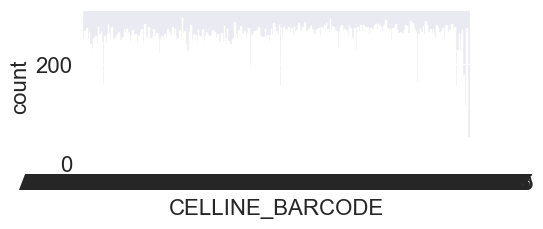

In [382]:
plt.subplots(figsize=(5,2))
sns.countplot(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(train_sample_barcode)]['CELLINE_BARCODE'])
plt.xlabel = None


/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CELLINE_BARCODE', ylabel='count'>

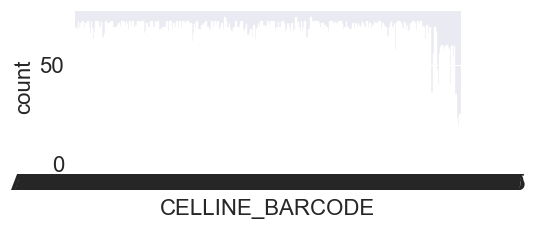

In [383]:
plt.subplots(figsize=(5,2))
sns.countplot(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(test+validation)]['CELLINE_BARCODE'])


Distribution over drug blind test

<AxesSubplot:xlabel='AUC', ylabel='Count'>

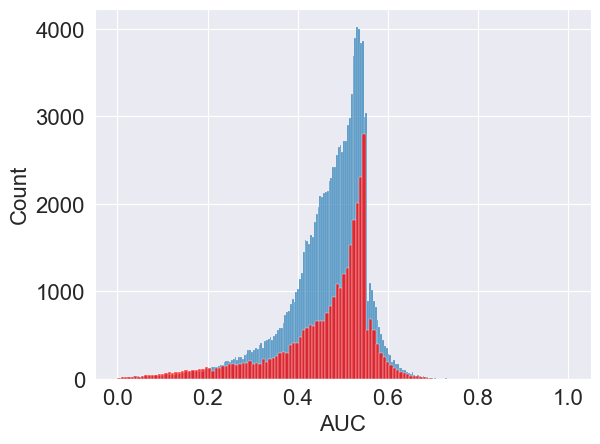

In [384]:
fig, ax = plt.subplots()
partition = ds.drug_blindtest_split()
train = partition['train']
test = partition['test']
validation = partition['validation']
sns.histplot(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(train)]['AUC'])
sns.histplot(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(test+validation)]['AUC'], color='red')

/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CELLINE_BARCODE', ylabel='count'>

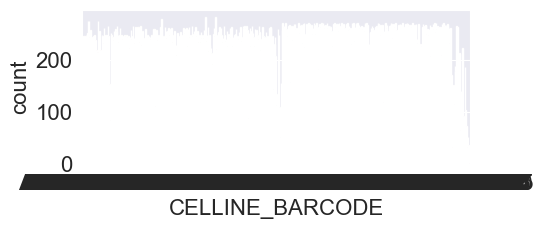

In [385]:
plt.subplots(figsize=(5,2))
sns.countplot(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(train)]['CELLINE_BARCODE'])

/Users/sunzehui/miniconda3/envs/tf/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CELLINE_BARCODE', ylabel='count'>

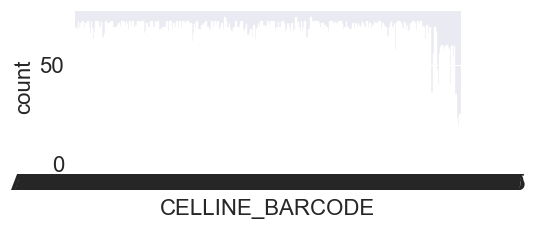

In [386]:
plt.subplots(figsize=(5,2))
sns.countplot(ds.processed_experiment[ds.processed_experiment['SAMPLE_BARCODE'].isin(test+validation)]['CELLINE_BARCODE'])

In [256]:
ds.processed_experiment['AUC'].quantile([0.33333, 0.6, 0.8])

0.33333    0.451483
0.60000    0.509936
0.80000    0.538351
Name: AUC, dtype: float64

In [257]:
lr_rate = 0.01
dropout_rate = .5
batch_size = 64
epochs = 5

# Split train, test and validation set for training and testing, build generators
partition = ds.split(data=ds.sample_barcode, validation=True)
train = partition['train']
test = partition['test']
validation = partition['validation']


In [258]:
train_generator = DataGenerator(sample_barcode=train, **ds.get_config(), batch_size=batch_size)
validation_generator = DataGenerator(sample_barcode=validation, **ds.get_config(), batch_size=batch_size)
test_generator = DataGenerator(sample_barcode=test, **ds.get_config(), batch_size=batch_size)

# Training parameters
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique([ds.labels[x] for x in train]),
                                                 y=[ds.labels[x] for x in train])

weights_dict = {i:w for i,w in enumerate(class_weights)}
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch, lr):
    if(epoch % 5 ==0 and epoch !=0):
        return lr*0.1
    else:
        return lr
reduce_lr = LearningRateScheduler(scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=10)


In [ ]:
# model building
model = multichannel_network(
    data=ds.omics_data, 
    drug_data=ds.drug_info,
    feature_contained=FEATURE, 
    train_sample_barcode=train) 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=
              [
                Precision(name="precision"),
                Recall(name="recall"),
                AUC(curve='ROC', name="AUC"),
                AUC(curve='PR', name="AUPRC")
              ]
            )

history = model.fit(
    x=train_generator, 
    epochs=epochs,
    validation_data=validation_generator, 
    callbacks=[reduce_lr],
    class_weight=weights_dict
                    )

scores = model.evaluate(x=test_generator) 
print(list(scores))


Evaluation

In [ ]:
all_generator = DataGenerator(sample_barcode=validation+test, **ds.get_config(), batch_size=batch_size)

In [ ]:
model.evaluate(x=all_generator)

save_model and load model

In [ ]:
tf.saved_model.save(model, 'CTRP_0.01_5-0.1_64_20_all_normalized')

In [259]:
_model_ = tf.saved_model.load('result/CTRP_0.01_5-0.1_64_15_all_updated')

define two useful functions

In [260]:
def prepare(candidate):
    celline_candidate = [i.split('_')[0] for i in candidate]
    drug_candidate = [i.split('_')[1] for i in candidate]
    feature = {}
    feature['fingerprint'] = ds.drug_info.drug_feature['fingerprint'].loc[drug_candidate].values.astype(np.float32)
    feature['rdkit2d'] = ds.drug_info.drug_feature['rdkit2d'].loc[drug_candidate].values.astype(np.float32)

    for i in ds.feature_contained:
        feature[i] = ds.omics_data[i].loc[celline_candidate].values.astype(np.float32)
    return feature

In [261]:
from tqdm import tqdm
import pandas as pd
def make_predict(model, candidate, ds, batch_size):
    """

    Args:
        candidate (list): list["CELLINE_DRUG"]
        ds (Dataset): Dataset Object
    """
    celline_candidate = [i.split('_')[0] for i in candidate]
    drug_candidate = [i.split('_')[1] for i in candidate]
    feature = {}
    for i in ds.feature_contained:
        feature[i] = ds.omics_data[i].loc[celline_candidate].values.astype(np.float32)
    
    feature['fingerprint'] = ds.drug_info.drug_feature['fingerprint'].loc[drug_candidate].values.astype(np.float32)
    feature['rdkit2d'] = ds.drug_info.drug_feature['rdkit2d'].loc[drug_candidate].values.astype(np.float32)
    chunks = []

    for i in range(0, len(candidate), batch_size):
        x = i
        sample = {i:feature[i][x:x+batch_size] for i in ds.feature_contained}
        sample.update(
            {
                "fingerprint": feature["fingerprint"][x:x+batch_size],
                "rdkit2d": feature['rdkit2d'][x:x+batch_size]
            }
        )
        chunks.append(sample)
    result = []

    for i in tqdm(chunks):
        result.append(model(i))
    result = np.concatenate(result, axis=-2)
    # result = result[0:len(candidate)]
    import pandas as pd
    df = pd.DataFrame(data=result, columns=['Sensitivity'])
    df['DRUG_NAME'] = drug_candidate
    df['CELL_LINE'] = celline_candidate
    return df 

# ANALYSIS

In [262]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## AUC, AUPRC and Confusion Matrix over test dataset

In [ ]:
pred_df = make_predict(model=_model_, candidate=test, ds=ds, batch_size=128)

In [ ]:
pred_df['true_labels'] = [ds.labels[i] for i in test]

In [ ]:
pred_df.rename(columns={"AUC_predicted": "Sensitivity"}, inplace=True)

In [ ]:
pred_df['pred_labels'] = [1 if i>0.5 else 0 for i in pred_df['Sensitivity']] # Define threshold

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=list(pred_df['true_labels']), y_pred=list(pred_df['pred_labels']))
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)


In [ ]:
RocCurveDisplay.from_predictions(y_true=list(pred_df['true_labels']), y_pred=list(pred_df['Sensitivity']),)

In [ ]:
PrecisionRecallDisplay.from_predictions(y_true=list(pred_df['true_labels']), y_pred=list(pred_df['Sensitivity']),)

## PRISM Holdout Validation

In [263]:
import pandas as pd
import numpy as np
from model.data import Dataset

In [264]:
prism = pd.read_csv('data/PRISM/secondary-screen-dose-response-curve-parameters.csv', low_memory=False)

In [265]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
prism['auc'] = minmax_scale(X=prism['auc'])


<AxesSubplot:xlabel='auc', ylabel='Count'>

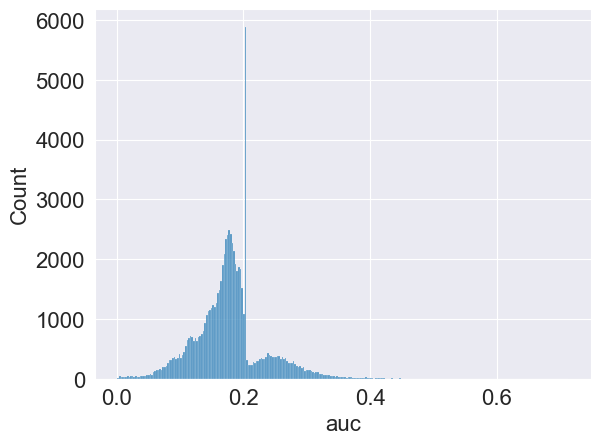

In [267]:
celline_barcode = set(ds.fpkm.index).intersection(*[ds.cnv.index, ds.mutation.index, ds.methylation.index])
lower, median, upper = prism['auc'].quantile([0.15,0.5,0.85]).values
IQR = upper - lower
lower_limit = lower - 1.5*IQR
upper_limit = upper + 1.5*IQR
trimmed_prism = prism[(prism['auc'] < upper_limit.data) &
                        (prism['auc'] > lower_limit.data)]
trimmed_prism = prism[prism['depmap_id'].isin(ds.celline_barcode)]
trimmed_prism.reset_index(drop=True, inplace=True)
trimmed_prism = trimmed_prism[trimmed_prism['name'].isin(ds.drug_info.all_drugs.index)]
sns.histplot(trimmed_prism['auc'])

In [268]:
trimmed_prism['auc'].quantile([0.3333, 0.66666, 0.9]) # threshold = 0.1728

0.33330    0.161001
0.66666    0.191847
0.90000    0.249080
Name: auc, dtype: float64

In [269]:
experiment_id = ["_".join((str(i), j)) for i,j in zip(trimmed_prism['depmap_id'], trimmed_prism['name'])]
experiment_df = pd.DataFrame()
experiment_df['SAMPLE_BARCODE'] = experiment_id
experiment_df['AUC'] = trimmed_prism['auc']
experiment_df['LABELS'] = [1 if i<0.16 else 0 for i in trimmed_prism['auc'] ]


In [270]:
experiment_candidate_prism = list(set(experiment_df['SAMPLE_BARCODE']))

In [271]:
pred_df = make_predict(model=_model_, candidate=experiment_candidate_prism, ds=ds, batch_size=32)

 16%|█▌        | 283/1819 [04:45<25:49,  1.01s/it]


KeyboardInterrupt: 

In [ ]:
ref = experiment_df[experiment_df['SAMPLE_BARCODE'].isin(experiment_candidate_prism)].drop_duplicates(subset='SAMPLE_BARCODE')
pred_df["SAMPLE_BARCODE"] = ["_".join((i,j)) for i,j in zip(pred_df['CELL_LINE'], pred_df['DRUG_NAME'])]
pred_df = pred_df.join(ref.set_index('SAMPLE_BARCODE'), on='SAMPLE_BARCODE')
pred_df['LABELS_PRED'] = [1 if i>=0.5 else 0 for i in pred_df['Sensitivity']]

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
sns.set()

import warnings
warnings.filterwarnings('ignore')


In [ ]:

fig = plt.figure(figsize=(8,6))

    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
fpr_test , tpr_test, thresholds_test = roc_curve(pred_df['true_labels'], pred_df['Sensitivity'])
fpr_prism, tpr_prism, thresholds_prism = roc_curve()
plt.plot(fpr_test, tpr_test, label= f"AUC_test: {roc_auc_score(pred_df['true_labels'], pred_df['Sensitivity'])}")


plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Predicted Scores Comparison between sensitive and insensitive drugs

In [ ]:
sns.violinplot(data=pred_df, x="true_labels", y="Sensitivity")

## Test Cancer(Lung, Colon, Breast, Stomach) Across drug types 

Find all cellines related 

In [17]:
model_list = pd.read_csv('data/raw_data/model_list_20230307.csv')
lung_ccl = model_list[(model_list['tissue'] == 'Lung') & 
                (model_list['tissue_status'] == 'Tumour')][['BROAD_ID','model_name']]
breast_ccl = model_list[(model_list['tissue'] == 'Breast') & 
                (model_list['tissue_status'] == 'Tumour')][['BROAD_ID','model_name']]
colo_ccl = model_list[((model_list['tissue'] == 'Small Intestine') | (model_list['tissue'] == 'Large Intestine')) & 
                (model_list['tissue_status'] == 'Tumour')][['BROAD_ID','model_name']]
stomach_ccl = model_list[(model_list['tissue'] == 'Stomach') & 
                (model_list['tissue_status'] == 'Tumour')][['BROAD_ID','model_name']]


In [ ]:
celline_barcode = set(ds.celline_barcode)
colo_ccl = set(colo_ccl).intersection(celline_barcode)
lung_ccl = set(lung_ccl).intersection(celline_barcode)
breast_ccl = set(breast_ccl).intersection(celline_barcode)
stomach_ccl = set(stomach_ccl).intersection(celline_barcode)
drug_candidate = set(ds.drug_info.all_drugs.index).difference(set(ds.processed_experiment['DRUG_NAME']))

In [ ]:
import itertools
l = {"colo": colo_ccl, "lung": lung_ccl, "breast": breast_ccl, "stomach": stomach_ccl}
experiment_candidate_dict = {name:itertools.product(i, drug_candidate) for name, i in l.items()}
for name, itm in experiment_candidate_dict.items():
    experiment_candidate_dict[name] = ["_".join(i) for i in itm]

In [ ]:
for name, itm in experiment_candidate_dict.items():
    experiment_candidate_dict[name] = make_predict(model=_model_, candidate=itm, ds=ds, batch_size=64)

In [ ]:
breast_drug_df = experiment_candidate_dict['breast'].groupby('DRUG_NAME').mean()
colo_drug_df = experiment_candidate_dict['colo'].groupby('DRUG_NAME').mean()
lung_drug_df = experiment_candidate_dict['lung'].groupby('DRUG_NAME').mean()
stomach_drug_df = experiment_candidate_dict['stomach'].groupby('DRUG_NAME').mean()

In [ ]:
breast_drug_df.sort_values(by='Sensitivity', ascending=False)

In [ ]:
colo_set = set(colo_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)
stomach_set = set(stomach_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)
lung_set = set(lung_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)
breast_set = set(breast_drug_df.sort_values(by='Sensitivity', ascending=False).head(30).index)

In [ ]:
common_set = colo_set.intersection(stomach_set, lung_set, breast_set)
print(common_set)

In [ ]:
print(f"Colon: {colo_set.difference(common_set)}")
print(f"Stomach: {stomach_set.difference(common_set)}")
print(f"Lung: {lung_set.difference(common_set)}")
print(f"Breast: {breast_set.difference(common_set)}")

In [1]:
import pandas as pd
breast_drug_df = pd.read_csv('result/breast_drug.csv')
lung_drug_df = pd.read_csv('result/lung_drug.csv')
stomach_drug_df = pd.read_csv('result/stomach_drug.csv')
colo_drug_df = pd.read_csv('result/colon_drug.csv')

In [2]:
drug_breast_rank = breast_drug_df.groupby('DRUG_NAME').mean()
drug_lung_rank = lung_drug_df.groupby('DRUG_NAME').mean()
drug_stomach_rank = stomach_drug_df.groupby('DRUG_NAME').mean()
drug_colo_rank = colo_drug_df.groupby('DRUG_NAME').mean()

In [9]:
drug_train = ['sunitinib', 'docetaxel', 'IU1', 'betulinic-acid', 'SNX-2112', 'CD-437', 'NVP-BEZ235', 'BMS-270394', 'dabrafenib', 'hyperforin', 'parbendazole', '5-fluorouracil', 'ABT-737', 'LY2183240', 'mitomycin-C', 'BMS-536924', 'oligomycin', 'ML006', 'R-428', 'AZD7762', 'COL-3', 'decitabine', 'doxorubicin', 'JW-480', 'fluvastatin', 'apicidin', 'TG100-115', 'SB-431542', 'ML210', 'belinostat', 'bexarotene', 'skepinone-L', 'quizartinib', 'necrostatin-7', 'ceranib-2', 'valdecoxib', 'imatinib', 'BMS-387032', 'BRD-K28456706', 'BMS-754807', 'HBX-41108', 'GSK1059615', 'tozasertib', 'tandutinib', 'GW-405833', 'indisulam', 'barasertib', 'SZ4TA2', 'foretinib', 'GANT-61', 'YM-155', 'PIK-93', 'venetoclax', 'canertinib', 'vemurafenib', 'sitagliptin', 'bendamustine', 'KHS-101', 'WZ-4002', 'zebularine', 'leptomycin', 'EX-527', 'lapatinib', 'NVP-TAE684', 'sotrastaurin', 'CHIR-99021', 'FQI-1', 'pluripotin', 'pyrazolanthrone', 'HC-067047', 'purmorphamine', 'NSC23766', 'obatoclax', 'RITA', 'mdivi-1', 'cerulenin', 'LRRK2-IN-1', 'avrainvillamide', 'azacitidine', 'evodiamine', 'nintedanib', 'AGK-2', 'salermide', 'ML239', 'BRD4132', 'vorapaxar', 'elocalcitol', 'triazolothiadiazine', 'GSK-J4', 'necrostatin-1', 'KU-0063794', 'gefitinib', 'IC-87114', 'regorafenib', 'methylstat', 'ML258', 'NVP-ADW742', 'O6-benzylguanine', 'GW-843682X', 'temsirolimus', 'pazopanib', 'I-BET-762', 'teniposide', 'dinaciclib', 'sorafenib', 'NVP-231', 'GSK2636771', 'temozolomide', 'JW-55', 'ETP-46464', 'cyanoquinoline', 'AT13387', 'gemcitabine', 'cytarabine', 'phloretin', 'PHA-793887', 'bortezomib', 'isoliquiritigenin', 'sirolimus', 'cyt387', 'LE-135', 'BRD4770', 'alisertib', 'linifanib', 'SJ-172550', 'fulvestrant', 'PF-184', 'ZSTK-474', 'afatinib', 'KU', 'BIX-01294', 'bosutinib', 'ibrutinib', 'WAY-362450', 'panobinostat', 'dexamethasone', 'SCH-529074', 'ciclosporin', 'CX-4945', 'SRT-1720', 'MK-0752', 'CHM-1', 'UNC0638', 'thalidomide', 'tipifarnib', 'epigallocatechin-gallate-(-)', 'tosedostat', 'pifithrin-alpha', 'tacrolimus', 'PCI-34051', 'trifluoperazine', 'STAT3-inhibitor-VI', 'N9-isopropylolomoucine', 'SB-525334', 'sildenafil', 'AT-406', 'procarbazine', 'myriocin', 'tamoxifen', 'spautin-1', 'bardoxolone', 'ouabain', 'alvocidib', 'cabozantinib', 'BI-2536', 'navitoclax', 'UNC0321', 'MK-2206', 'TPCA-1', 'neratinib', 'SR1001', 'BAM7', 'GSK4112', 'tigecycline', 'methotrexate', 'myricetin', 'prochlorperazine', 'PRL-3', 'ML334', 'OSI-027', 'CI-976', 'narciclasine', 'AZ3146', 'PAC-1', 'tivantinib', 'pandacostat', 'SID', 'PD-153035', 'etomoxir', 'tubastatin-A', 'GMX-1778', 'ML203', 'B02', 'BRD9876', 'PDMP', 'lovastatin', 'SGX523', 'Bax', 'saracatinib', 'CCT036477', 'FK-866', 'AM-580', 'AZD8055', 'SU11274', 'DBeQ', 'pitstop2', 'PI-103', 'PD-318088', 'dacarbazine', 'nelarabine', 'clofarabine', 'A-804598', 'AZD4547', 'erlotinib', 'CIL56', 'selumetinib', 'R406', 'carboplatin', 'SB-225002', 'JW-74', 'importazole', 'GSK461364', 'TGX-221', 'necrosulfonamide', 'ruxolitinib', 'MG-132', 'NSC-95397', 'olaparib', 'topotecan', 'PX-12', 'tacedinaline', 'tanespimycin', 'KH-CB19', 'AZD6482', 'tretinoin', 'doramapimod', 'CAY10594', 'MI-2', 'GDC-0879', 'I-BET151', 'NSC30930', 'sonidegib', 'TW-37', 'ML031', 'alpelisib', 'RG4733', 'GPP-78', 'lomeguatrib', 'NVP-BSK805', 'PF-573228', 'Ko143', 'CID-5951923', 'cisplatin', 'BIBR-1532', 'AZD7545', 'BMS-195614', 'triptolide', 'KU-60019', 'PYR-41', 'pevonedistat', 'ML050', '944328-88-5', 'cytochalasin-B', 'ML162', 'AT7867', 'istradefylline', 'itraconazole', 'gossypol', 'OSI-930', 'pifithrin-mu', 'STF-31', 'SCH-79797', 'SKI-II', 'AZD1480', 'CAY10576', 'ICG-001', 'dasatinib', 'MK-1775', 'VER-155008', 'abiraterone', 'veliparib', 'ML311', 'KPT-185', 'FGIN-1-27', 'Merck60', '3-Cl-AHPC', 'idelalisib', 'homoharringtonine', 'BMS-345541', 'manumycin', 'trametinib', 'neopeltolide', 'LY2157299', 'cimetidine', 'vandetanib', 'MIRA-1', 'cyclophosphamide', 'Piplartine', 'ML083', 'RG108', 'NSC632839', 'lenvatinib', 'SR8278', 'YK-4-279', 'simvastatin', 'HLI', 'nakiterpiosin', 'PF-750', 'JQ1-(+)', 'staurosporine', 'brivanib', 'PF-03758309', 'ISX-9', 'parthenolide', 'axitinib', 'chlorambucil', 'KI-8751', 'NSC48300', 'camptothecin', 'tivozanib', 'KU-55933', 'nutlin-3', 'SMER-3', 'serdemetan', 'C6-ceramide', 'cediranib', 'WP1130', 'masitinib', 'BRD6340', 'semagacestat', 'linsitinib', 'entinostat', 'MLN2480', 'MI-1', 'ixazomib', 'CD-1530', 'ML029', 'bleomycin', 'rigosertib', 'BEC', 'darinaparsin', 'paclitaxel', 'birinapant', 'PRIMA1', 'erastin', 'ifosfamide', 'KX2-391', 'etoposide', 'ciclopirox', 'CH55', 'BRD9647', 'RAF265', 'AC-55649', 'nilotinib', 'MGCD-265', 'stemregenin-1', 'fedratinib', 'L-685458', 'WZ8040', 'curcumin', 'GDC-0941', 'PF-4800567', 'vorinostat', 'PLX4720', 'KW-2449', 'niclosamide', 'SB-743921', 'vincristine', 'crizotinib', 'GSK-3-inhibitor-IX', 'fingolimod', 'oxaliplatin']
ccl_train = ['ACH-000265', 'ACH-000696', 'ACH-000440', 'ACH-000108', 'ACH-000305', 'ACH-000653', 'ACH-000703', 'ACH-000002', 'ACH-000420', 'ACH-000857', 'ACH-000311', 'ACH-000260', 'ACH-000212', 'ACH-000155', 'ACH-000341', 'ACH-000894', 'ACH-000823', 'ACH-000427', 'ACH-000595', 'ACH-000056', 'ACH-000837', 'ACH-000532', 'ACH-000858', 'ACH-000684', 'ACH-000699', 'ACH-000375', 'ACH-000147', 'ACH-000879', 'ACH-000971', 'ACH-000763', 'ACH-000810', 'ACH-000271', 'ACH-000488', 'ACH-000546', 'ACH-000308', 'ACH-000007', 'ACH-000980', 'ACH-000716', 'ACH-000346', 'ACH-000058', 'ACH-000863', 'ACH-000951', 'ACH-000885', 'ACH-000193', 'ACH-000448', 'ACH-000350', 'ACH-000828', 'ACH-000360', 'ACH-000267', 'ACH-000938', 'ACH-000092', 'ACH-000176', 'ACH-000560', 'ACH-000571', 'ACH-000121', 'ACH-000238', 'ACH-000478', 'ACH-000417', 'ACH-000249', 'ACH-000965', 'ACH-000688', 'ACH-000408', 'ACH-000914', 'ACH-000552', 'ACH-000745', 'ACH-000113', 'ACH-000750', 'ACH-000357', 'ACH-000106', 'ACH-000332', 'ACH-000008', 'ACH-000530', 'ACH-000054', 'ACH-000356', 'ACH-000968', 'ACH-000035', 'ACH-000465', 'ACH-000749', 'ACH-000704', 'ACH-000347', 'ACH-000718', 'ACH-000784', 'ACH-000910', 'ACH-000644', 'ACH-000738', 'ACH-000282', 'ACH-000886', 'ACH-000510', 'ACH-000643', 'ACH-000855', 'ACH-000800', 'ACH-000236', 'ACH-000675', 'ACH-000664', 'ACH-000579', 'ACH-000558', 'ACH-000803', 'ACH-000778', 'ACH-000689', 'ACH-000319', 'ACH-000129', 'ACH-000622', 'ACH-000548', 'ACH-000767', 'ACH-000244', 'ACH-000947', 'ACH-000048', 'ACH-000780', 'ACH-000191', 'ACH-000464', 'ACH-000915', 'ACH-000788', 'ACH-000376', 'ACH-000301', 'ACH-000958', 'ACH-000247', 'ACH-000744', 'ACH-000963', 'ACH-000019', 'ACH-000395', 'ACH-000439', 'ACH-000447', 'ACH-000146', 'ACH-000451', 'ACH-000151', 'ACH-000859', 'ACH-000751', 'ACH-000772', 'ACH-000544', 'ACH-000004', 'ACH-000432', 'ACH-000747', 'ACH-000827', 'ACH-000242', 'ACH-000627', 'ACH-000210', 'ACH-000351', 'ACH-000245', 'ACH-000776', 'ACH-000486', 'ACH-000391', 'ACH-000913', 'ACH-000162', 'ACH-000948', 'ACH-000609', 'ACH-000493', 'ACH-000363', 'ACH-000613', 'ACH-000204', 'ACH-000515', 'ACH-000105', 'ACH-000826', 'ACH-000394', 'ACH-000945', 'ACH-000364', 'ACH-000381', 'ACH-000890', 'ACH-000937', 'ACH-000505', 'ACH-000501', 'ACH-000506', 'ACH-000583', 'ACH-000361', 'ACH-000046', 'ACH-000656', 'ACH-000607', 'ACH-000023', 'ACH-000217', 'ACH-000422', 'ACH-000348', 'ACH-000896', 'ACH-000496', 'ACH-000569', 'ACH-000900', 'ACH-000276', 'ACH-000740', 'ACH-000400', 'ACH-001203', 'ACH-000824', 'ACH-000811', 'ACH-000259', 'ACH-000672', 'ACH-000101', 'ACH-001233', 'ACH-000678', 'ACH-000521', 'ACH-000326', 'ACH-000219', 'ACH-000117', 'ACH-000396', 'ACH-000012', 'ACH-000835', 'ACH-000516', 'ACH-000053', 'ACH-000819', 'ACH-000294', 'ACH-000329', 'ACH-000021', 'ACH-000100', 'ACH-000853', 'ACH-000991', 'ACH-000449', 'ACH-000754', 'ACH-000336', 'ACH-000315', 'ACH-000527', 'ACH-000074', 'ACH-000094', 'ACH-000518', 'ACH-000269', 'ACH-000677', 'ACH-000201', 'ACH-000354', 'ACH-000304', 'ACH-000136', 'ACH-000792', 'ACH-000075', 'ACH-000840', 'ACH-000620', 'ACH-000657', 'ACH-000050', 'ACH-000953', 'ACH-000223', 'ACH-000309', 'ACH-000817', 'ACH-000137', 'ACH-000869', 'ACH-000452', 'ACH-000416', 'ACH-000918', 'ACH-000841', 'ACH-000916', 'ACH-000769', 'ACH-000371', 'ACH-000969', 'ACH-000621', 'ACH-000924', 'ACH-000374', 'ACH-000270', 'ACH-000724', 'ACH-000648', 'ACH-000960', 'ACH-000663', 'ACH-000243', 'ACH-000940', 'ACH-000838', 'ACH-000149', 'ACH-000431', 'ACH-000168', 'ACH-001306', 'ACH-000639', 'ACH-000295', 'ACH-000832', 'ACH-000847', 'ACH-000978', 'ACH-000794', 'ACH-000107', 'ACH-000524', 'ACH-000809', 'ACH-001190', 'ACH-000902', 'ACH-000752', 'ACH-000562', 'ACH-000865', 'ACH-000472', 'ACH-000401', 'ACH-000580', 'ACH-000257', 'ACH-000171', 'ACH-001023', 'ACH-000956', 'ACH-000159', 'ACH-000065', 'ACH-000380', 'ACH-000373', 'ACH-000551', 'ACH-000755', 'ACH-000566', 'ACH-000177', 'ACH-000615', 'ACH-000303', 'ACH-000939', 'ACH-000372', 'ACH-000988', 'ACH-000856', 'ACH-000359', 'ACH-000957', 'ACH-000986', 'ACH-000450', 'ACH-000930', 'ACH-000725', 'ACH-000932', 'ACH-000042', 'ACH-000189', 'ACH-000055', 'ACH-000006', 'ACH-000743', 'ACH-000522', 'ACH-000565', 'ACH-000114', 'ACH-000378', 'ACH-000366', 'ACH-000293', 'ACH-000979', 'ACH-000733', 'ACH-000603', 'ACH-000414', 'ACH-000874', 'ACH-000649', 'ACH-000878', 'ACH-000399', 'ACH-000425', 'ACH-000637', 'ACH-000997', 'ACH-000652', 'ACH-000188', 'ACH-000929', 'ACH-000864', 'ACH-000263', 'ACH-000570', 'ACH-000090', 'ACH-000045', 'ACH-000770', 'ACH-000970', 'ACH-000367', 'ACH-000821', 'ACH-000174', 'ACH-000287', 'ACH-000650', 'ACH-000599', 'ACH-000922', 'ACH-000587', 'ACH-000880', 'ACH-000292', 'ACH-000795', 'ACH-000221', 'ACH-000920', 'ACH-000748', 'ACH-000232', 'ACH-000200', 'ACH-000903', 'ACH-000277', 'ACH-000665', 'ACH-000061', 'ACH-000822', 'ACH-000423', 'ACH-000424', 'ACH-000156', 'ACH-000596', 'ACH-000186', 'ACH-000030', 'ACH-000636', 'ACH-000231', 'ACH-000626', 'ACH-000169', 'ACH-000717', 'ACH-000116', 'ACH-000783', 'ACH-000719', 'ACH-000403', 'ACH-000815', 'ACH-000353', 'ACH-000883', 'ACH-000614', 'ACH-000893', 'ACH-000860', 'ACH-000362', 'ACH-000789', 'ACH-000225', 'ACH-000944', 'ACH-000611', 'ACH-000491', 'ACH-000955', 'ACH-000547', 'ACH-000473', 'ACH-000966', 'ACH-000888', 'ACH-000892', 'ACH-000985', 'ACH-000226', 'ACH-000936', 'ACH-000062', 'ACH-000481', 'ACH-000787', 'ACH-000722', 'ACH-001138', 'ACH-000768', 'ACH-000640', 'ACH-000911', 'ACH-000334', 'ACH-000793', 'ACH-000974', 'ACH-000638', 'ACH-000248', 'ACH-000470', 'ACH-000806', 'ACH-000756', 'ACH-000322', 'ACH-000617', 'ACH-000291', 'ACH-000132', 'ACH-000852', 'ACH-000112', 'ACH-000943', 'ACH-000060', 'ACH-000228', 'ACH-000698', 'ACH-000469', 'ACH-000679', 'ACH-000015', 'ACH-000235', 'ACH-000457', 'ACH-000574', 'ACH-000693', 'ACH-000508', 'ACH-000096', 'ACH-000183', 'ACH-000290', 'ACH-000434', 'ACH-000667', 'ACH-000298', 'ACH-000666', 'ACH-000605', 'ACH-000804', 'ACH-000078', 'ACH-000567', 'ACH-000572', 'ACH-000318', 'ACH-000138', 'ACH-000139', 'ACH-000335', 'ACH-000358', 'ACH-000935', 'ACH-000781', 'ACH-000288', 'ACH-000802', 'ACH-000989', 'ACH-000934', 'ACH-000674', 'ACH-000098', 'ACH-000087', 'ACH-000983', 'ACH-000349', 'ACH-000720', 'ACH-000040', 'ACH-000099', 'ACH-000927', 'ACH-000514', 'ACH-000917', 'ACH-000343', 'ACH-000568', 'ACH-000973', 'ACH-000438', 'ACH-000849', 'ACH-000441', 'ACH-000881', 'ACH-000843', 'ACH-000926', 'ACH-000120', 'ACH-000816', 'ACH-000998', 'ACH-000145', 'ACH-000161', 'ACH-000024', 'ACH-000059', 'ACH-000181', 'ACH-000882', 'ACH-000142', 'ACH-000555', 'ACH-000489', 'ACH-000411', 'ACH-000702', 'ACH-000038', 'ACH-000091', 'ACH-000680', 'ACH-000694', 'ACH-000647', 'ACH-000962', 'ACH-000525', 'ACH-000681', 'ACH-000876', 'ACH-000775', 'ACH-000081', 'ACH-000383', 'ACH-001039', 'ACH-000052', 'ACH-000919', 'ACH-000352', 'ACH-000227', 'ACH-000536', 'ACH-000250', 'ACH-000437', 'ACH-000871', 'ACH-000585', 'ACH-000730', 'ACH-000320', 'ACH-000365', 'ACH-000846', 'ACH-000633', 'ACH-000670', 'ACH-000697', 'ACH-000624', 'ACH-000124', 'ACH-000233', 'ACH-000433', 'ACH-000258', 'ACH-001307', 'ACH-000073']

In [14]:
drug_colo_rank.sort_values(by='Sensitivity', ascending=False)[['Sensitivity']]

,Sensitivity
DRUG_NAME,
UMI-77,1.000000
vinorelbine,1.000000
OF-1,1.000000
uprosertib,1.000000
AZD5582,1.000000
...,...
BAM7,0.014558
PYR-41,0.008626
Zoledronic,0.000000


In [53]:
_df = drug_colo_rank.loc[~drug_colo_rank.index.isin(drug_train)].sort_values(by='Sensitivity', ascending=False)[['Sensitivity']]

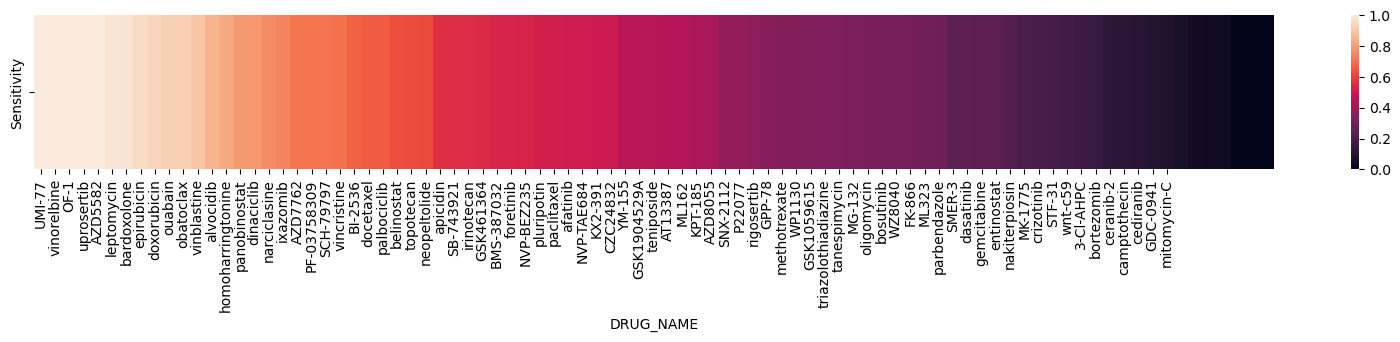

In [59]:
plt.subplots(figsize=(20,2))
g = sns.heatmap(_df.T, 
                xticklabels = list(drug_colo_rank.sort_values(by='Sensitivity', ascending=False)[['Sensitivity']][:80].index),
                )

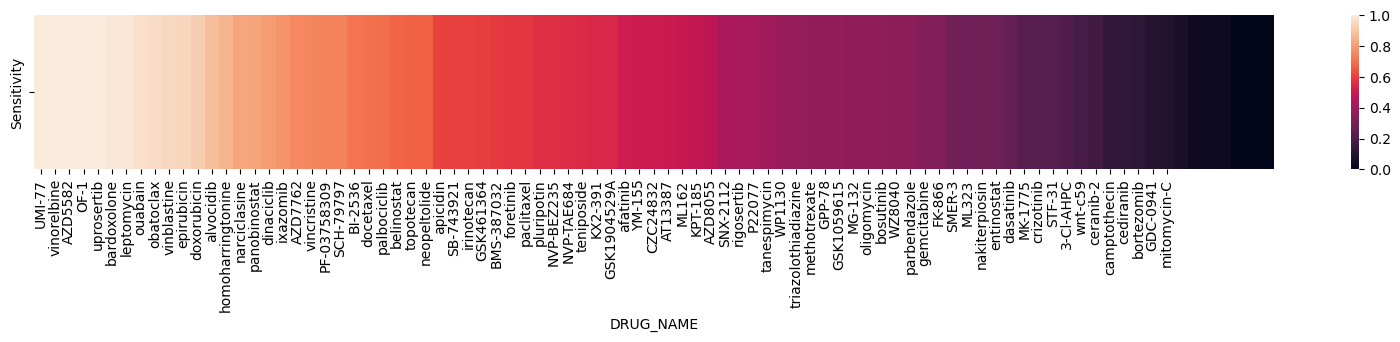

In [60]:
plt.subplots(figsize=(20,2))
g = sns.heatmap(drug_lung_rank.loc[~drug_lung_rank.index.isin(drug_train)].sort_values(by='Sensitivity', ascending=False)[['Sensitivity']].T, 
                xticklabels = list(drug_lung_rank.sort_values(by='Sensitivity', ascending=False)[['Sensitivity']][:80].index),
                )

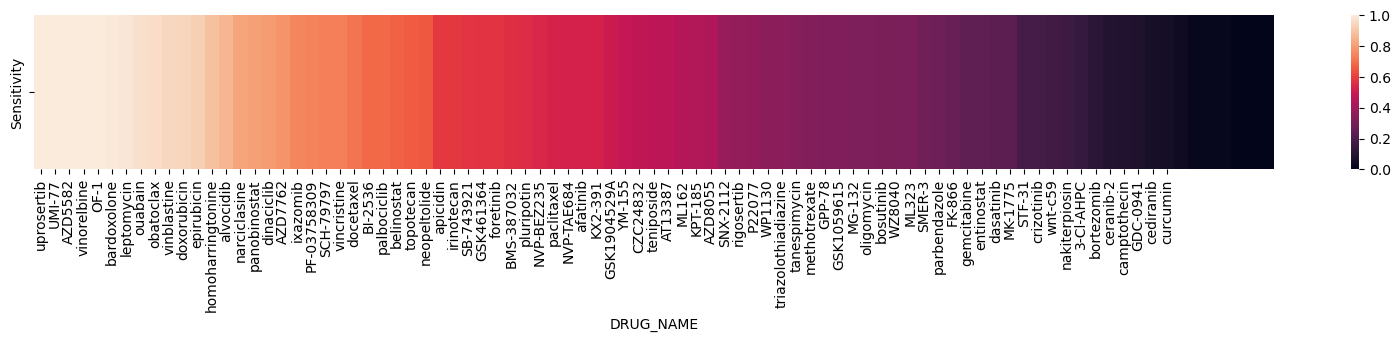

In [61]:
plt.subplots(figsize=(20,2))
g = sns.heatmap(drug_stomach_rank.loc[~drug_stomach_rank.index.isin(drug_train)].sort_values(by='Sensitivity', ascending=False)[['Sensitivity']].T, 
                xticklabels = list(drug_stomach_rank.sort_values(by='Sensitivity', ascending=False)[['Sensitivity']][:80].index),
                )

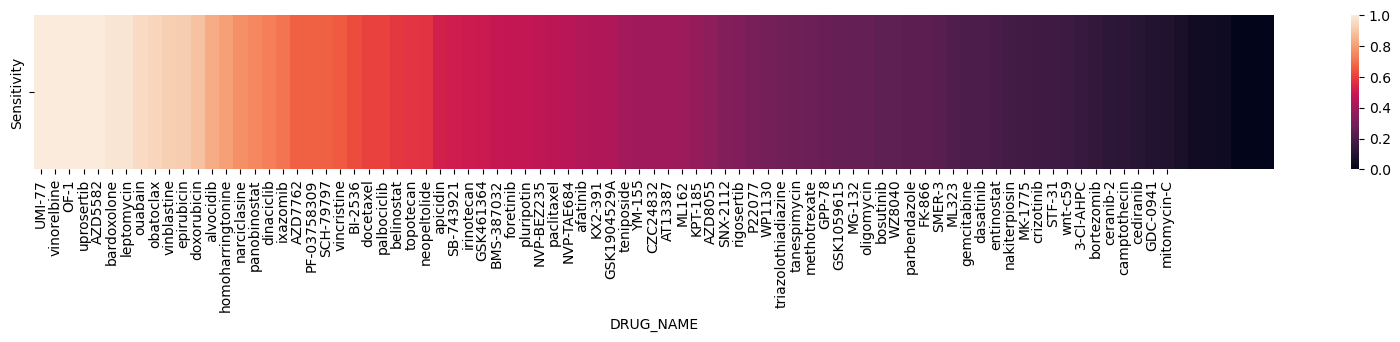

In [62]:
plt.subplots(figsize=(20,2))
g = sns.heatmap(drug_breast_rank.loc[~drug_breast_rank.index.isin(drug_train)].sort_values(by='Sensitivity', ascending=False)[['Sensitivity']].T, 
                xticklabels = list(drug_breast_rank.sort_values(by='Sensitivity', ascending=False)[['Sensitivity']][:80].index),
                )

## Test type-specific drugs Across Cancer Types

Gefitinib Lung Cancer-specific **inhibitor of EGFR and AKT1**

In [63]:
gefitinib_entry = ["_".join((i, "gefitinib")) for i in ds.celline_barcode]
gefitinib_df = make_predict(model=model, candidate = gefitinib_entry, ds=ds, batch_size=64)
lung_ccl = model_list[(model_list['tissue'] == 'Lung') & 
                (model_list['tissue_status'] == 'Tumour')]['model_name']
gefitinib_df[gefitinib_df['CELL_LINE'].isin(lung_ccl)]

NameError: name 'make_predict' is not defined

In [393]:
gefitinib_df = pd.read_csv('result/gefitinib.csv')
model_list = pd.read_csv('data/raw_data/model_list_20230307.csv')
lung_ccl = model_list[(model_list['tissue'] == 'Lung') & 
                (model_list['tissue_status'] == 'Tumour')][['model_name', 'BROAD_ID']]
breast_ccl = model_list[(model_list['tissue'] == 'Breast') & 
                (model_list['tissue_status'] == 'Tumour')][['model_name', 'BROAD_ID']]

lung_gefitinib_df = gefitinib_df[gefitinib_df['CELL_LINE'].isin(lung_ccl['BROAD_ID'])]
lung_gefitinib_df = lung_gefitinib_df.join(lung_ccl.set_index('BROAD_ID'), on='CELL_LINE')
breast_gefitinib_df = gefitinib_df[gefitinib_df['CELL_LINE'].isin(breast_ccl['BROAD_ID'])]
breast_gefitinib_df = breast_gefitinib_df.join(breast_ccl.set_index('BROAD_ID'), on='CELL_LINE')


In [388]:
cancer_drivers = pd.read_csv("data/raw_data/mutations_summary_20230202.csv")
a = dict(zip(model_list['BROAD_ID'], model_list['model_id']))

In [184]:
binary_gefitinib_df = gefitinib_df
binary_gefitinib_df['Sensitivity'] = [1 if i>.5 else 0 for i in gefitinib_df['Sensitivity']]

In [185]:
pos_list = list(gefitinib_df[gefitinib_df['Sensitivity'] == 1]['CELL_LINE'])
neg_list = list(gefitinib_df[gefitinib_df['Sensitivity'] == 0]['CELL_LINE'])

In [186]:
c = Counter(cancer_drivers[cancer_drivers['model_id'].isin([a[i] for i in pos_list])]['gene_symbol'])

In [187]:
cancer_drivers[cancer_drivers['model_id'].isin([a[i] for i in pos_list])]

,gene_id,gene_symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
1348,SIDG38363,TP53,SIDM01067,p.V218L,r.842g>c,c.652G>C,True,False,missense,0.7500,True,Sanger,HCC-827
1349,SIDG07457,EGFR,SIDM01067,p.E746K,r.2497g>a,c.2236G>A,True,False,missense,0.1739,True,Sanger,HCC-827
1638,SIDG26775,RB1,SIDM01071,p.S402fs*8,r.1389delU,c.1202delT,True,False,frameshift,0.9537,True,Sanger,HCC-33
2220,SIDG13927,KMT2D,SIDM00548,p.Q4473*,r.13417c>u,c.13417C>T,True,False,nonsense,0.6667,True,Sanger,LK-2
2221,SIDG38363,TP53,SIDM00548,p.V272M,r.1004g>a,c.814G>A,True,False,missense,1.0000,True,Sanger,LK-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9855,SIDG02209,BCOR,SIDM00116,p.E756*,r.3050g>u,c.2266G>T,True,False,nonsense,1.0000,True,Sanger,NCI-H522
9919,SIDG05393,CREBBP,SIDM01071,p.A1824T,r.6280g>a,c.5470G>A,True,False,missense,0.3750,True,Sanger,HCC-33
9920,SIDG38363,TP53,SIDM01071,p.C242Y,r.915g>a,c.725G>A,True,False,missense,0.9348,True,Sanger,HCC-33
9921,SIDG36119,SP140,SIDM01071,p.?,r.169-2a>u,c.60-2A>T,True,False,ess_splice,0.3864,True,Sanger,HCC-33


In [210]:
train_sample_barcode = list(pd.read_csv('result/train_sample_barcode.csv')['0'])

In [215]:
l = set(["_".join((i, 'gefitinib')) for i in gefitinib_df['CELL_LINE']]).intersection(train_sample_barcode)
l = list(l)


In [217]:
l = set(i.split("_")[0] for i in l)

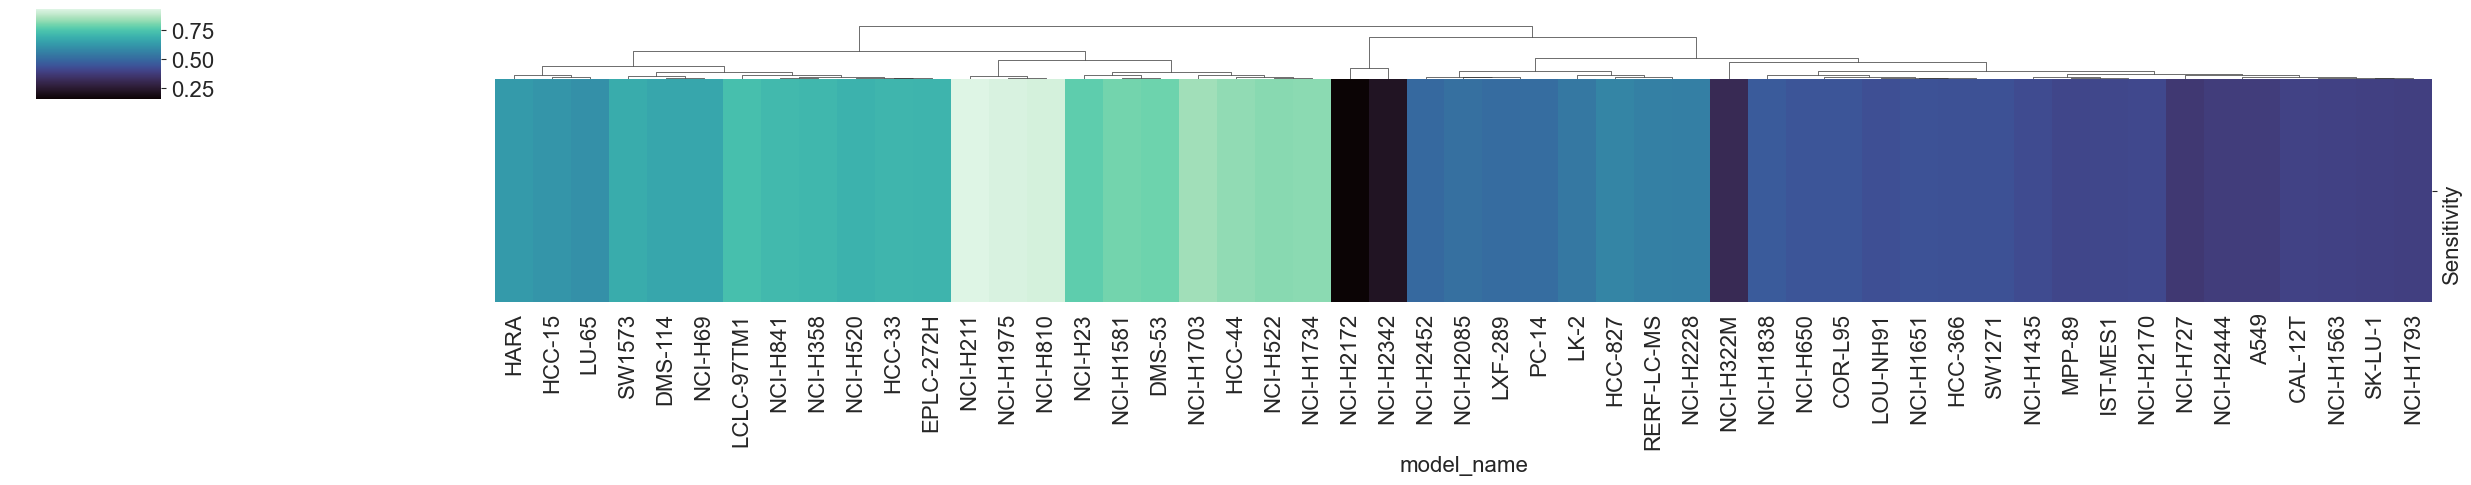

In [237]:
g = sns.clustermap(lung_gefitinib_df[['model_name', 'Sensitivity']].set_index('model_name').T, row_cluster=False, cmap="mako",figsize=(25,5))

In [306]:
sample = ["_".join(i) for i in zip(breast_gefitinib_df['CELL_LINE'], breast_gefitinib_df['DRUG_NAME'])]

In [309]:
breast_gefitinib_df

,Unnamed: 0,Sensitivity,DRUG_NAME,CELL_LINE,model_name
38,38,0.543507,gefitinib,ACH-000276,HCC38
84,84,0.634823,gefitinib,ACH-000859,HCC1954
120,120,0.454170,gefitinib,ACH-000374,HCC1143
186,186,0.679351,gefitinib,ACH-000857,CAL-85-1
220,220,0.601873,gefitinib,ACH-000930,HCC1569
331,331,0.424923,gefitinib,ACH-000725,HCC202
347,347,0.526366,gefitinib,ACH-000699,HCC1395
359,359,0.190058,gefitinib,ACH-000223,HCC1937
360,360,0.464966,gefitinib,ACH-000288,BT-549
370,370,0.437755,gefitinib,ACH-000624,HCC1806


In [310]:
set(sample).difference(train_sample_barcode)

{'ACH-000223_gefitinib',
 'ACH-000568_gefitinib',
 'ACH-000725_gefitinib',
 'ACH-000755_gefitinib',
 'ACH-000930_gefitinib'}

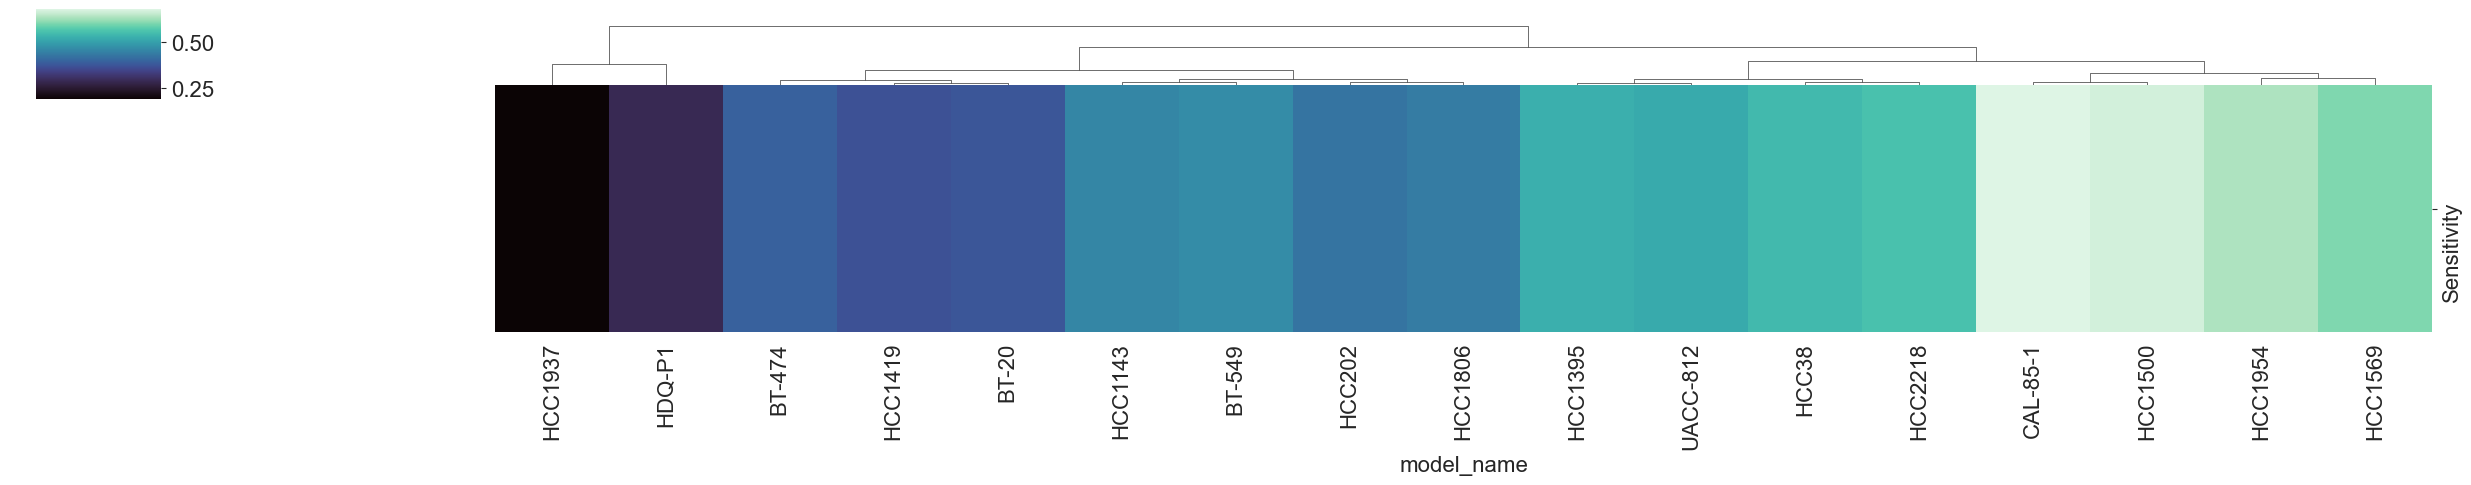

In [238]:
sns.clustermap(breast_gefitinib_df[['model_name', 'Sensitivity']].set_index('model_name').T, row_cluster=False, cmap="mako",figsize=(25,5))

In [274]:
pd.read_csv('data/raw_data/CCLE_EGFR_MUT.tsv', sep="\t")

,Study of Origin,Sample ID,Cancer Type,Cancer Type Detailed,Protein Change,Annotation,Functional Impact,Mutation Type,Variant Type,Copy #,...,Sex,Site of Finding,Site Subtype 1,Site Subtype 2,Site Subtype 3,Subtype,Supplements,TMB (nonsynonymous),Tumor Type,Type Refined
0,"Cancer Cell Line Encyclopedia (Broad, 2019)",NCIH1975_LUNG,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,T790M,"OncoKB: Oncogenic, level_1, level_r1;reVUE: no...","MutationAssessor: impact: neutral, score: -0.0...",Missense_Mutation,SNP,Amp,...,Female,NaN,NS,NS,NS,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NaN,11.366667,lung_NSC,lung_NSC
1,"Cancer Cell Line Encyclopedia (Broad, 2019)",NCIH2172_LUNG,Non-Small Cell Lung Cancer,Non-Small Cell Lung Cancer,L858R,"OncoKB: Oncogenic, level_1, resistance NA;reVU...","MutationAssessor: impact: high, score: 3.65;SI...",Missense_Mutation,SNP,Diploid,...,Female,NaN,NS,NS,NS,"Non-Small Cell Lung Cancer (NSCLC), unspecified",NaN,49.633333,lung_NSC,lung_NSC
2,"Cancer Cell Line Encyclopedia (Broad, 2019)",NCIH3255_LUNG,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,L858R,"OncoKB: Oncogenic, level_1, resistance NA;reVU...","MutationAssessor: impact: high, score: 3.65;SI...",Missense_Mutation,SNP,Amp,...,NaN,NaN,NS,NS,NS,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NaN,8.933333,lung_NSC,lung_NSC
3,"Cancer Cell Line Encyclopedia (Broad, 2019)",NCIH1975_LUNG,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,L858R,"OncoKB: Oncogenic, level_1, resistance NA;reVU...","MutationAssessor: impact: high, score: 3.65;SI...",Missense_Mutation,SNP,Amp,...,Female,NaN,NS,NS,NS,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NaN,11.366667,lung_NSC,lung_NSC
4,"Cancer Cell Line Encyclopedia (Broad, 2019)",PC14_LUNG,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,E746_A750del,"OncoKB: Oncogenic, level_1, resistance NA;reVU...",MutationAssessor: NA;SIFT: NA;Polyphen-2: NA,In_Frame_Del,DEL,Amp,...,NaN,NaN,NS,NS,NS,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NaN,12.200000,lung_NSC,lung_NSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,"Cancer Cell Line Encyclopedia (Broad, 2019)",SNU869_BILIARY_TRACT,Hepatobiliary Cancer,Extrahepatic Cholangiocarcinoma,EGFR-APBB2 Fusion,"OncoKB: Unknown, level NA, resistance NA;reVUE...",MutationAssessor: NA;SIFT: NA;Polyphen-2: NA,fusion,NaN,Diploid,...,NaN,NaN,bile_duct,NS,NS,"Cholangiocarcinoma, extrahepatic",NaN,7.800000,bile_duct,bile_duct
105,"Cancer Cell Line Encyclopedia (Broad, 2019)",KG1C_CENTRAL_NERVOUS_SYSTEM,Glioma,Oligodendroglioma,EGFR-DBNL Fusion,"OncoKB: Unknown, level NA, resistance NA;reVUE...",MutationAssessor: NA;SIFT: NA;Polyphen-2: NA,fusion,NaN,Diploid,...,Male,NaN,brain,NS,NS,Oligodendroglioma,NaN,6.700000,glioma,glioma
106,"Cancer Cell Line Encyclopedia (Broad, 2019)",SNU869_BILIARY_TRACT,Hepatobiliary Cancer,Extrahepatic Cholangiocarcinoma,EGFR-UBC Fusion,"OncoKB: Unknown, level NA, resistance NA;reVUE...",MutationAssessor: NA;SIFT: NA;Polyphen-2: NA,fusion,NaN,Diploid,...,NaN,NaN,bile_duct,NS,NS,"Cholangiocarcinoma, extrahepatic",NaN,7.800000,bile_duct,bile_duct
107,"Cancer Cell Line Encyclopedia (Broad, 2019)",U118MG_CENTRAL_NERVOUS_SYSTEM,Glioma,Astrocytoma,DIDO1-EGFR Fusion,"OncoKB: Unknown, level NA, resistance NA;reVUE...",MutationAssessor: NA;SIFT: NA;Polyphen-2: NA,fusion,NaN,Diploid,...,NaN,NaN,brain,NS,NS,Astrocytoma,NaN,5.800000,glioma,glioma


In [300]:
EGFR_mut = pd.read_csv('data/raw_data/CCLE_EGFR_MUT.tsv', sep="\t")
# EGFR_mut = EGFR_mut[EGFR_mut['Tumor Type'] == "lung_NSC"]
EGFR_mut_barcode = ["_".join(i) for i in zip(EGFR_mut['DepMap ID'], ['gefitinib']*len(EGFR_mut))]
EGFR_mut_barcode = set(EGFR_mut_barcode).difference(train_sample_barcode)
EGFR_mut_barcode = set(EGFR_mut_barcode).intersection(["_".join((i.split("_")[0], 'gefitinib')) for i in ds.sample_barcode])

In [297]:
df = pd.read_csv('result/EGFR_mut_all.csv').join(model_list[['BROAD_ID', 'model_name', 'cancer_type']].set_index('BROAD_ID'), on='CELL_LINE')

In [301]:
EGFR_mut_barcode

{'ACH-000012_gefitinib',
 'ACH-000168_gefitinib',
 'ACH-000356_gefitinib',
 'ACH-000515_gefitinib',
 'ACH-000938_gefitinib',
 'ACH-000953_gefitinib',
 'ACH-000978_gefitinib',
 'ACH-000989_gefitinib',
 'ACH-000991_gefitinib',
 'ACH-000998_gefitinib',
 'ACH-001203_gefitinib'}

In [304]:
df[df['CELL_LINE'].isin([i.split("_")[0] for i in EGFR_mut_barcode])]

,Sensitivity,DRUG_NAME,CELL_LINE,model_name,cancer_type
0,0.572300,gefitinib,ACH-000012,HCC-827,Non-Small Cell Lung Carcinoma
4,0.821020,gefitinib,ACH-000168,NOMO-1,Acute Myeloid Leukemia
8,0.130269,gefitinib,ACH-000356,MKN45,Gastric Carcinoma
11,0.702419,gefitinib,ACH-000515,HCC-33,Small Cell Lung Carcinoma
34,0.956428,gefitinib,ACH-000938,NALM-6,B-Lymphoblastic Leukemia
36,0.899897,gefitinib,ACH-000953,SUP-T1,T-Lymphoblastic Leukemia
42,0.257010,gefitinib,ACH-000978,EN,Endometrial Carcinoma
44,0.895177,gefitinib,ACH-000989,SNU-175,Colorectal Carcinoma
45,0.834209,gefitinib,ACH-000991,SNU-81,Colorectal Carcinoma
46,0.464540,gefitinib,ACH-000998,CW-2,Colorectal Carcinoma


## SVM and GBDT

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from model.data import Dataset
from model.nn import CalculateSimilarity

In [ ]:
temp_ds = Dataset(dataset='CTRP', feature_contained=['cnv'])

In [ ]:
paritition = temp_ds.split(data=ds.sample_barcode, validation=True)
feature = prepare(candidate=paritition['train'])

In [ ]:
test_feature = prepare(candidate=paritition['test'])

In [ ]:
from functools import reduce
import numpy as np
feature = reduce(lambda x,y: np.append(x,y,axis=1), feature.values())
test_feature = reduce(lambda x,y: np.append(x,y,axis=1), test_feature.values())

In [ ]:
labels = np.array([[ds.labels[i]] for i in paritition['train']]).ravel()
test_y = np.array([[ds.labels[i]] for i in paritition['test']]).ravel()

In [ ]:
clf = RandomForestClassifier()
clf.fit(feature, labels)

In [ ]:
pred_y = clf.predict(X = test_feature)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=test_y, y_pred=pred_y)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)

In [ ]:
PrecisionRecallDisplay.from_predictions(y_true=test_y, y_pred=pred_y,)

## Consensus Clustering

In [ ]:
ds.omics_data['cnv'].to_csv("data/data_visual/cnv.csv")
ds.omics_data['gene_expression'].to_csv('data/data_visual/gene_expression.csv')
ds.omics_data['methylation'].to_csv('data/data_visual/methylation.csv')
ds.omics_data['mutation'].to_csv('data/data_visual/mutation.csv')

CCL Feature

In [ ]:
model.encoded_feature.clear()
temp = []
for i in range(len(ds.omics_data['cnv'])):
    print(i)
    temp.append({
        'fingerprint': np.zeros(shape=(1,881)),
        'rdkit2d': np.zeros(shape=(1,200,)),
        'cnv': ds.omics_data['cnv'].iloc[i].values,
        'gene_expression': ds.omics_data['gene_expression'].iloc[i].values,
        'mutation': ds.omics_data['mutation'].iloc[i].values,
        'methylation': ds.omics_data['methylation'].iloc[i].values, 
    })
for i in temp:
    model.__call__(inputs = i, training=False)
ccl_feature = model.encoded_feature

Drug Feature

In [ ]:
model.encoded_feature.clear()
temp = []
for i in range(len(ds.drug_info.drug_feature['fingerprint'])):
    temp.append({
        'fingerprint': ds.drug_info.drug_feature['fingerprint'].iloc[i].values,
        'rdkit2d': ds.drug_info.drug_feature['rdkit2d'].iloc[i].values,
        'cnv': np.zeros(shape=(1,ds.omics_data['cnv'].shape[1])),
        'gene_expression': np.zeros(shape=(1,ds.omics_data['gene_expression'].shape[1])),
        'mutation': np.zeros(shape=(1,ds.omics_data['mutation'].shape[1])),
        'methylation': np.zeros(shape=(1,ds.omics_data['methylation'].shape[1])), 
    })
for i in temp:
    model.__call__(inputs = i, training=False)
drug_feature = model.encoded_feature

In [ ]:
ccl_list = list(ds.omics_data['cnv'])

ccl

In [ ]:
ccl_encoded_feature = np.stack([ccl_feature[i][0][256:] for i in range(len(ds.omics_data['cnv']))])

drug

In [ ]:
drug_encoded_feature = np.stack([drug_feature[i][0][:256] for i in range(len(ds.drug_info.drug_feature['fingerprint']))])

Drug and CCL encoded feature after exclusion of outliers

In [149]:
import pandas as pd
import numpy as np
from scipy import stats
# Exclude Outliers
drug_encoded_df = pd.DataFrame(data=drug_encoded_feature, index=ds.drug_info.drug_feature['fingerprint'].index)
drug_encoded_df = drug_encoded_df[(np.abs(stats.zscore(drug_encoded_df)) < 3).all(axis=1)]

NameError: name 'drug_encoded_feature' is not defined

In [ ]:
ccl_encoded_df = pd.DataFrame(data=ccl_encoded_feature, index=ds.omics_data['cnv'].index)

In [ ]:
ccl_encoded_df.T.to_csv("ccl_encoded.csv", index=None)
drug_encoded_df.T.to_csv("drug_encoded.csv", index=None)

Enrichment after `R` `ConsensusClusterPlus`

In [166]:
encoded_clrs = pd.read_csv('./encoded_clrs.csv').T.rename(columns={0:"Cluster"})
drug_clrs = pd.read_csv('./drug_clrs.csv').T.rename(columns={0:"Cluster"}) 

In [167]:
df = ds.processed_experiment[['DRUG_NAME', 'CELLINE_BARCODE', 'AUC']]

In [168]:
encoded_clrs = pd.concat([encoded_clrs[encoded_clrs['Cluster'] == i] for i in [1,2,3,4]])
drug_clrs = pd.concat([drug_clrs[drug_clrs['Cluster'] == i] for i in [1,2,3,4,5]]) 

In [169]:
drug_clrs = drug_clrs.loc[set(df['DRUG_NAME']).intersection(drug_clrs.index)]
drug_clrs = pd.concat([drug_clrs[drug_clrs['Cluster'] == i] for i in [1,2,3,4]]) 

/var/folders/wc/rh6kv76j5dxdxqbbrkkc3bn80000gn/T/ipykernel_61553/4247276350.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  drug_clrs = drug_clrs.loc[set(df['DRUG_NAME']).intersection(drug_clrs.index)]


In [170]:
one = encoded_clrs[encoded_clrs['Cluster'] == 1]
two = encoded_clrs[encoded_clrs['Cluster'] == 2]
three = encoded_clrs[encoded_clrs['Cluster'] == 3]
four = encoded_clrs[encoded_clrs['Cluster'] == 4]
five = encoded_clrs[encoded_clrs['Cluster'] == 5]

In [171]:
encoded_clrs = pd.concat([two, four, three, one])

In [172]:
one = drug_clrs[drug_clrs['Cluster'] == 1]
two = drug_clrs[drug_clrs['Cluster'] == 2]
three = drug_clrs[drug_clrs['Cluster'] == 3]
four = drug_clrs[drug_clrs['Cluster'] == 4]
four = drug_clrs[drug_clrs['Cluster'] == 5]


In [173]:
drug_clrs = pd.concat([ five, three,two, four, one])

In [174]:
df

,DRUG_NAME,CELLINE_BARCODE,AUC
0,CIL56,ACH-000956,0.520195
1,CIL56,ACH-000948,0.543001
2,CIL56,ACH-000973,0.529162
3,CIL56,ACH-000411,0.540491
4,CIL56,ACH-001306,0.411665
...,...,...,...
156938,ML031,ACH-000827,0.566065
156939,ML031,ACH-000332,0.560271
156940,ML031,ACH-000469,0.447866
156941,ML031,ACH-000570,0.541451


In [175]:
df = pd.pivot_table(data=df, values=['AUC'], index=['DRUG_NAME'], columns=['CELLINE_BARCODE'])
df.fillna(1, inplace=True)
df = df['AUC']
df = df.loc[drug_clrs.index]
df = df[list(encoded_clrs.index)[::-1]]

In [176]:
df[df>.45]=1
df[df<=.45]=0

In [177]:
s = {i:j for i,j in zip(model_list['BROAD_ID'], model_list['model_name'])}

In [178]:
_df = df.rename(columns=s)

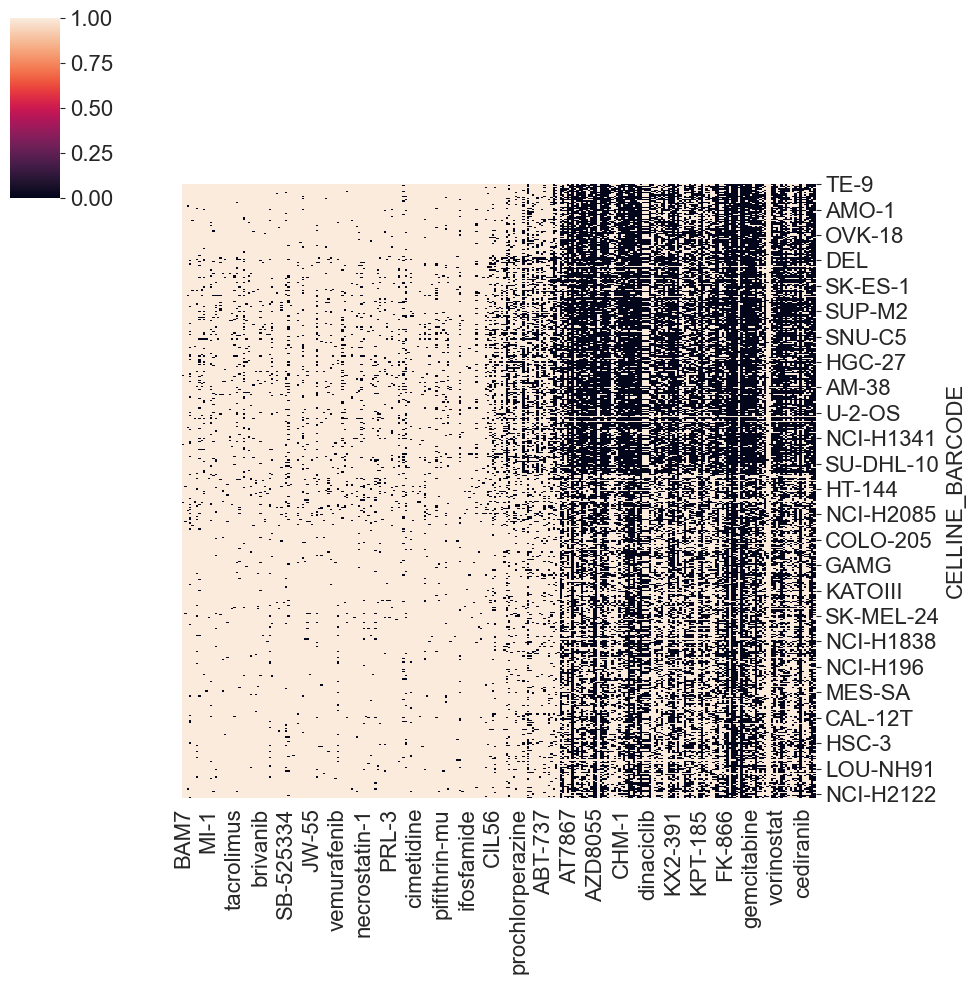

In [194]:
g = sns.clustermap(_df.T, col_cluster=False, row_cluster=False)

## Feature Ablation

In [154]:
import seaborn as sns

In [155]:
combination = ["cnv", "methylation", "gene_expression", "mutation",
               "cnv+methylation", "cnv+gene_expression", "cnv+mutation",
               "methylation+gene_expression", "methylation+mutation",
               "gene_expression+mutation",
               "cnv+methylation+gene_expression", "cnv+methylation+mutation",
               "cnv+gene_expression+mutation", "methylation+gene_expression+mutation",
               "cnv+methylation+gene_expression+mutation"]

In [156]:
feature_ablation = pd.read_csv("feature_ablation.csv")

In [157]:
feature_ablation['combination'] = combination

In [158]:
s = {}
for i in feature_ablation['combination']:
    s[i] = feature_ablation[feature_ablation['combination'] == i][['precision', 'recall', 'auc', 'auc_1']].values.tolist()[0]

In [160]:
from matplotlib import pyplot as plt


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(), bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

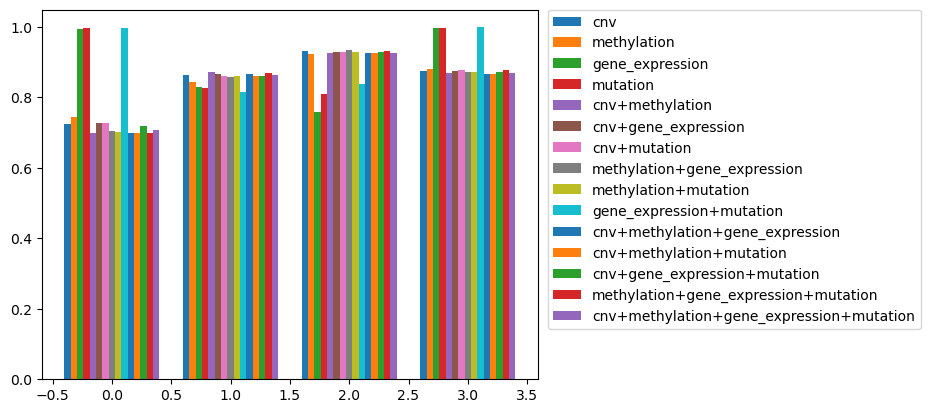

In [161]:
fig, ax = plt.subplots()

bar_plot(ax, s, total_width=0.8, single_width=1, legend=True)

## 5-Fold Cross Validation

In [193]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from config_path import *
%matplotlib inline


In [194]:
ctrp_result = pd.read_csv('CTRP_5-Fold_result.csv')
gdsc_result = pd.read_csv('GDSC_5-Fold_result.csv')

In [195]:
gdsc_result['class'] = 'GDSC'
ctrp_result['class'] = 'CTRP'

In [196]:
result = pd.concat([gdsc_result, ctrp_result])

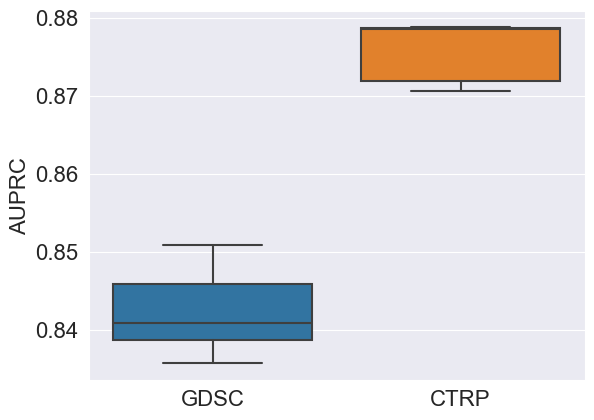

In [197]:
# Set the default text font size
plt.rc('font', size=16)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)
# Set the legend font size
plt.rc('legend', fontsize=18)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)


fig, ax = plt.subplots()
sns.set_style("darkgrid")
sns.boxplot(data=result, x='class', y='auprc', ax=ax)
ax.set_xlabel(None)
ax.set_ylabel("AUPRC")

plt.show()

In [ ]:
# Set the default text font size
plt.rc('font', size=16)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)
# Set the legend font size
plt.rc('legend', fontsize=18)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)


fig, ax = plt.subplots()
sns.set_style("darkgrid")
sns.boxplot(data=result, x='class', y='auroc', ax=ax)
ax.set_xlabel(None)
ax.set_ylabel("AUROC")

plt.show()

In [ ]:
from scipy.stats import ttest_ind

ttest_ind(a=ctrp_result['auroc'], b=gdsc_result['auroc'])